In [1]:
import pandas as pd
import scipy, researchpy
from researchpy import ttest
import os, glob
import numpy as np

In [2]:
import json
import mpu.io

In [3]:
folder = '../log_gbm/results'
# '../{}/*{}*'.format(folder, exp)

In [ ]:
# find /mnt/experiments/gbm_infer/ -type f -name '*.csv'

data = pd.read_csv('paths_to_csv.txt', header = None)
import shlex, subprocess,time
base_command = """scp gpu_server_kate:{path} /home/kate/projects/brain-mri-processing-pipeline/main_pipeline/log_gbm/results/ """
for i in range(0,len(data)):
    print(data[0].iloc[i])
    command_to_run = base_command.format(path = data[0].iloc[i])
    command_to_run = shlex.split(command_to_run)
    process = subprocess.Popen(command_to_run,shell=False)
    time.sleep(1)

## Creating the joint table:

In [12]:
os.listdir(folder)

['.ipynb_checkpoints',
 'metrics_gbm_2a_interp_fold-0.csv',
 'metrics_gbm_2b_n4_fold-2.csv',
 'metrics_gbm_3a_atlas_fold-2.csv',
 'metrics_gbm_3a_atlas_aug_300_fold-2.csv',
 'metrics_gbm_3b_n4_fold-1.csv',
 'metrics_gbm_3a_susan_fold-1.csv',
 'metrics_gbm_2a_interp_fold-1.csv',
 'metrics_gbm_TCGA_GBM_fold-2.csv',
 'metrics_gbm_3aatlas_withoutbrain_label_from_3aatlas_fold-1.csv',
 'metrics_gbm_5_ss_label_from_3atlas_fold-1.csv',
 'metrics_gbm_3a_atlas_aug_300_fold-0.csv',
 'metrics_gbm_3a_susan_fold-2.csv',
 'metrics_gbm_TCGA_GBM_fold-1.csv',
 'metrics_gbm_5_ss_shared_fold-1.csv',
 'metrics_gbm_3a_atlas_fold-1.csv',
 'metrics_gbm_3c_n4_susan_fold-0.csv',
 'metrics_gbm_2b_n4_fold-0.csv',
 'metrics_gbm_2c_n4_susan_fold-0.csv',
 'metrics_gbm_3aatlas_withoutbrain_label_from_3aatlas_fold-0.csv',
 'metrics_gbm_3c_n4_susan_fold-1.csv',
 'metrics_gbm_3c_n4_susan_fold-2.csv',
 'metrics_gbm_2a_interp_fold-2.csv',
 'metrics_gbm_5_ss_shared_fold-2.csv',
 'metrics_gbm_7a_resample_fold-1.csv',
 'metr

In [13]:
!ls ..

1_reg.py	3a_atlas.py	4a_resamp.py  6_hist.py  log_schw
2a_interp.py	3b_n4.sh	4b_n4.sh      log_bgpd	 metrics
2b_n4.sh	3c_n4_susan.sh	4d_susan.sh   log_gbm	 misc
2c_n4_susan.sh	3d_susan.sh	5_ss.py       log_lgg	 utils


In [15]:
gbm_seed = mpu.io.read('../utils/gbm_seed.json')
folder = '../log_gbm/results_native/'
def make_df_fold(folder, exp, list_fold_0 =gbm_seed['fold_0'], list_fold_1=gbm_seed['fold_1'], list_fold_2=gbm_seed['fold_2']):
    """ for most of experiments name of experiment `exp` should include `_f`
    """
    assert(len(glob.glob('{}/*{}*'.format(folder, exp))) == 3)
    for fold in glob.glob('{}/*{}*'.format(folder, exp)):
        if 'fold-0' in fold:
            df_fold_0 = pd.read_csv(fold)
            df_fold_0 = df_fold_0[df_fold_0['Ids'].isin(list_fold_0)]
        elif 'fold-1' in fold:
            df_fold_1 = pd.read_csv(fold)
            df_fold_1 = df_fold_1[df_fold_1['Ids'].isin(list_fold_1)]
        elif 'fold-2' in fold:                  
            df_fold_2 = pd.read_csv(fold)
            df_fold_2 = df_fold_2[df_fold_2['Ids'].isin(list_fold_2)]
            
    result_df = pd.concat([df_fold_0,df_fold_1,df_fold_2])
    result_df = result_df.drop(result_df.columns[0], axis = 1).reset_index(drop=True)
    return result_df

In [16]:
df_1 = make_df_fold(folder,'1_reg_f', gbm_seed['fold_0'],  gbm_seed['fold_1'],  gbm_seed['fold_2'])
df_2 = make_df_fold(folder,'1_reg_aug',  gbm_seed['fold_0'],  gbm_seed['fold_1'],  gbm_seed['fold_2'])

In [17]:
def ttest_pair(metric, df_1, df_2, name_1, name_2, correction = None):
    return ttest(df_1[metric], df_2[metric], group1_name = name_1,
                 group2_name= name_2, equal_variances=False, paired=True, correction = 8).iloc[4].values[1]

In [19]:
ttest_pair('Surface_dice_1', df_1, df_2, '1_reg_f', '1_reg_aug')

0.0038

In [20]:
fixed = '1_reg_f'
moving = ['1_reg_aug']
metrics = ['Surface_dice_1']
result = pd.DataFrame()
df_1 = make_df_fold(folder, fixed)
for exp in moving:
    df_2 = make_df_fold(folder, exp)
    for metric in metrics:
            
        result = result.append({'Experiment': fixed,
                                    'Metric' : metric,
                                    'Mean': np.round(df_1[metric].mean(),3),
                                    'STD': np.round(df_1[metric].std(),3)},  
                                   ignore_index = True)
        p_value = ttest_pair(metric, df_1, df_2, fixed, exp, correction = len(moving))
        result = result.append({'Experiment': exp,
                                    'Metric' : metric,
                                    'Mean': np.round(df_2[metric].mean(),3),
                                    'STD': np.round(df_2[metric].std(),3),
                                    'p_value': np.round(p_value,3),
                                    'criterion' : (p_value < 0.050),
                                    },  
                                   ignore_index = True)

In [22]:
def make_main_table(folder, fixed, moving, metrics, list_fold_0=gbm_seed['fold_0'], list_fold_1=gbm_seed['fold_1'], list_fold_2=gbm_seed['fold_2']):
    result = pd.DataFrame()
    df_1 = make_df_fold(folder,fixed, list_fold_0, list_fold_1, list_fold_2)
    
    for exp in moving:
        df_2 = make_df_fold(folder,exp, list_fold_0, list_fold_1, list_fold_2)
        for metric in metrics:
            
            result = result.append({'Experiment': fixed,
                                    'Metric' : metric,
                                    'Mean': np.round(df_1[metric].mean(),3),
                                    'STD': np.round(df_1[metric].std(),3)},  
                                   ignore_index = True)
            p_value = ttest_pair(metric, df_1, df_2, fixed, exp, correction = len(moving))
            result = result.append({'Experiment': exp,
                                    'Metric' : metric,
                                    'Mean': np.round(df_2[metric].mean(),3),
                                    'STD': np.round(df_2[metric].std(),3),
                                    'p_value': np.round(p_value,3),
                                    'criterion' : (p_value < 0.050),
                                    },  
                                   ignore_index = True)
    return result

In [23]:
make_main_table(folder, '1_reg_f', ['1_reg_aug'],
                ['Surface_dice_1']).drop_duplicates(['Experiment','Metric' ]).sort_values(['Mean'])

,Experiment,Metric,Mean,STD,criterion,p_value
0,1_reg_f,Surface_dice_1,0.251,0.138,NaN,NaN
1,1_reg_aug,Surface_dice_1,0.259,0.139,1.0,0.004


In [25]:
make_main_table(folder, '2a_interp', ['6_hist'],
                ['Surface_dice_1']).drop_duplicates(['Experiment','Metric' ]).sort_values(['Mean'])

,Experiment,Metric,Mean,STD,criterion,p_value
1,6_hist,Surface_dice_1,0.667,0.204,0.0,0.714
0,2a_interp,Surface_dice_1,0.673,0.194,NaN,NaN


In [30]:
make_main_table(folder, '1_reg_f', ['2a_interp','3a_atlas_f', '4a_resamp_f'],
                ['Surface_dice_1']).drop_duplicates(['Experiment','Metric' ]).sort_values(['Mean'])

,Experiment,Metric,Mean,STD,criterion,p_value
0,1_reg_f,Surface_dice_1,0.251,0.138,NaN,NaN
5,4a_resamp_f,Surface_dice_1,0.655,0.193,1.0,0.0
1,2a_interp,Surface_dice_1,0.673,0.194,1.0,0.0
3,3a_atlas_f,Surface_dice_1,0.683,0.190,1.0,0.0


In [32]:
make_main_table(folder,'4a_resamp_f', ['3a_atlas_f', '2a_interp' ],
                ['Surface_dice_1']).drop_duplicates(['Experiment','Metric' ])

,Experiment,Metric,Mean,STD,criterion,p_value
0,4a_resamp_f,Surface_dice_1,0.655,0.193,NaN,NaN
1,3a_atlas_f,Surface_dice_1,0.683,0.190,1.0,0.00
3,2a_interp,Surface_dice_1,0.673,0.194,1.0,0.01


In [34]:
make_main_table(folder, '3a_atlas_f', ['3b_n4','3d_susan','6_hist', '5_ss','3a_atlas_aug', '4a_resamp_aug'],
                ['Surface_dice_1']).drop_duplicates(['Experiment'])

AssertionError: 

In [153]:
make_main_table(folder, '3a_atlas_aug', ['4a_resamp_aug'],
                ['Surface_dice_1']).drop_duplicates(['Experiment','Metric' ]).sort_values(['Mean'])

,Experiment,Metric,Mean,STD,criterion,p_value
1,4a_resamp_aug,Surface_dice_1,0.696,0.194,0.0,0.473
0,3a_atlas_aug,Surface_dice_1,0.698,0.193,NaN,NaN


In [36]:
df_3 = make_df_fold(folder,'6_hist', gbm_seed['fold_0'],  gbm_seed['fold_1'],  gbm_seed['fold_2'])

In [37]:
make_main_table(folder,'7a_resample' , ['3a_atlas_f','2a_interp_f', ],
                ['Dice_1','Surface_dice_1','Sensitivity_1','Precision_1'], 
                df_fold_0, df_fold_1, df_fold_2).drop_duplicates(['Experiment','Metric' ])

NameError: name 'df_fold_0' is not defined

In [193]:
os.listdir('../log_gbm/results_native/')

['3d_susan_fold-0.csv',
 '4a_resamp_fold-0.csv',
 '.ipynb_checkpoints',
 'metrics_gbm_1_reg_aug_fold-2.csv',
 '5_ss_fold-2.csv',
 'metrics_gbm_1_reg_aug_fold-0.csv',
 '3a_atlas_fold-2.csv',
 '3a_atlas_aug_fold-1.csv',
 '3d_susanfold-0.csv',
 '3d_susan_fold-1.csv',
 '2a_interp_fold-1.csv',
 '3d_susanfold-2.csv',
 '3b_n4fold-0.csv',
 '2a_interpfold-1.csv',
 '3b_n4fold-2.csv',
 '3a_atlas_fold-0.csv',
 '6_hist_fold-0.csv',
 '5_ss_fold-0.csv',
 '3d_susan_fold-2.csv',
 'metrics_gbm_1_reg_fold-1.csv',
 '6_hist_fold-1.csv',
 '6_hist_fold-2.csv',
 '1_reg_labels.csv',
 '2a_interp_fold-2.csv',
 '3a_atlas_fold-1.csv',
 'metrics_gbm_1_reg_fold-2.csv',
 '3d_susanfold-1.csv',
 '4a_resamp_aug_fold-2.csv',
 'metrics_gbm_1_reg_aug_fold-1.csv',
 '3a_atlas_aug_fold-2.csv',
 'metrics_gbm_1_reg_fold-0.csv',
 '2a_interp_fold-0.csv',
 '2a_interpfold-2.csv',
 '4a_resamp_aug_fold-0.csv',
 '3b_n4fold-1.csv',
 '4a_resamp_fold-1.csv',
 '3a_atlas_aug_fold-0.csv',
 '4a_resamp_fold-2.csv',
 '2a_interpfold-0.csv',
 '5

#### 3. Taking only needed subjects for analysis

In [4]:
import shutil
for i in os.listdir('/anvar/public_datasets/preproc_study/gbm/inference/metrcis/'):
#     shutil.copy('/anvar/public_datasets/preproc_study/gbm/inference/metrcis/6_hist_fold-1.csv','../log_gbm/results_native/')

IndentationError: expected an indented block (1301941392.py, line 3)

In [5]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/inference/metrcis/')

['4a_resamp_fold-0.csv',
 '2a_interp_fold-0.csv',
 '4a_resamp_aug_fold-1.csv',
 '3d_susan_fold-0.csv',
 '5_ss_fold-2.csv',
 '3a_atlas_fold-2.csv',
 '5_ss_mask_native_fold-1.csv',
 '3b_n4fold-0.csv',
 '3a_atlas_fold-1.csv',
 '3c_n4_susan_fold-2.csv',
 '4a_resamp_fold-1.csv',
 '5_ss_mask_native_fold-0.csv',
 '3a_atlas_aug_fold-1.csv',
 '4a_resamp_aug_fold-0.csv',
 '6_hist_fold-1.csv',
 '2a_interp_fold-2.csv',
 '2a_interpfold-2.csv',
 '6_hist_fold-2.csv',
 '5_ss_fold-0.csv',
 '4a_resamp_aug_fold-2.csv',
 '3d_susan_fold-1.csv',
 '2a_interp_fold-1.csv',
 '4a_resamp_fold-2.csv',
 '5_ss_fold-1.csv',
 '3d_susan_fold-2.csv',
 '3b_n4fold-2.csv',
 '6_hist_fold-0.csv',
 '3a_atlas_aug_fold-2.csv',
 '5_ss_mask_native_fold-2.csv',
 '3d_susanfold-1.csv',
 '3c_n4_susan_fold-1.csv',
 '3d_susanfold-2.csv',
 '2a_interpfold-1.csv',
 '3b_n4fold-1.csv',
 '3a_atlas_fold-0.csv',
 '2a_interpfold-0.csv',
 '3c_n4_susan_fold-0.csv',
 '1_reg_labels.csv',
 '3a_atlas_aug_fold-0.csv']

In [6]:
folder = '../log_gbm/results_native/'
result_df = pd.DataFrame(columns = df_1.columns)
result_df['fold'] = ''
result_df['exp'] = ''

NameError: name 'df_1' is not defined

In [538]:
for i in os.listdir(folder):
    try:
        temp_df = pd.read_csv(folder + i)
        temp_df['fold'] = ''
        temp_df['fold'] = int(i.split('-')[1][:-4])
#         print(i.split('-')[1][:-4])
        temp_df['exp'] = ''
        temp_df['exp'] = i.split('fold')[0]
        print(i.split('fold')[0], i.split('-')[1][:-4])
        if int(i.split('-')[1][:-4]) == 0:
                temp_df = temp_df[temp_df['Ids'].isin(gbm_seed['fold_0'])]
        elif int(i.split('-')[1][:-4]) == 1:
                temp_df = temp_df[temp_df['Ids'].isin(gbm_seed['fold_1'])]
        elif int(i.split('-')[1][:-4]) == 2:                 
                temp_df = temp_df[temp_df['Ids'].isin(gbm_seed['fold_2'])]
        result_df = result_df.append(temp_df, ignore_index = True)
    except:
        pass
    
result_df.to_csv('../log_gbm/results_native/pivot_table_native_space.csv')
    
# result_df.to_csv('../log_gbm/results_native/pivot_table_pred_space.csv')

3d_susan_ 0
4a_resamp_ 0
metrics_gbm_1_reg_aug_ 2
5_ss_ 2
3c_n4_susan_ 2
metrics_gbm_1_reg_aug_ 0
3a_atlas_ 2
3a_atlas_aug_ 1
3d_susan_ 1
2a_interp_ 1
3b_n4 0
3b_n4 2
3a_atlas_ 0
6_hist_ 0
5_ss_ 0
3d_susan_ 2
metrics_gbm_1_reg_ 1
6_hist_ 1
6_hist_ 2
2a_interp_ 2
3a_atlas_ 1
metrics_gbm_1_reg_ 2
4a_resamp_aug_ 2
metrics_gbm_1_reg_aug_ 1
3c_n4_susan_ 0
3a_atlas_aug_ 2
metrics_gbm_1_reg_ 0
2a_interp_ 0
5_ss_mask_native_ 1
5_ss_mask_native_ 0
4a_resamp_aug_ 0
3b_n4 1
4a_resamp_ 1
3a_atlas_aug_ 0
5_ss_mask_native_ 2
3c_n4_susan_ 1
4a_resamp_ 2
5_ss_ 1
4a_resamp_aug_ 1


In [7]:
# result_df = pd.read_csv('../log_gbm/results_native/pivot_table.csv')

In [8]:
columns_3 = ['Dice_3', 'Hausdorff95_3','Sensitivity_3','Specificity_3','Surface_dice_3','Precision_3']
columns_2 = ['Dice_2', 'Hausdorff95_2',  'Sensitivity_2','Specificity_2', 'Surface_dice_2','Precision_2' ]
columns_1 = ['Dice_1',  'Hausdorff95_1','Sensitivity_1',  'Specificity_1','Surface_dice_1', 'Precision_1']

In [9]:
exp_1 = 'metrics_gbm_1_reg_'
exp_2 = 'metrics_gbm_1_reg_aug_'
for i in enumerate(zip([exp_1, exp_2], [df_1, df_2])):
    print(i[1][1])

NameError: name 'df_1' is not defined

In [10]:
columns_3 = ['Dice_3', 'Hausdorff95_3','Surface_dice_3','Sensitivity_3','Specificity_3','Precision_3']
columns_2 = ['Dice_2', 'Hausdorff95_2',  'Surface_dice_2','Sensitivity_2','Specificity_2', 'Precision_2' ]
columns_1 = ['Dice_1',  'Hausdorff95_1','Surface_dice_1','Sensitivity_1',  'Specificity_1', 'Precision_1']

In [11]:
df = pd.DataFrame()

exp_1 = 'metrics_gbm_1_reg_'
exp_2 = 'metrics_gbm_1_reg_aug_'
fold_isin = [0,1,2]
columns = columns_3

df_1 = result_df[(result_df['exp'] == exp_1)&(result_df['fold'].isin(fold_isin))].sort_values(['Ids']).drop(['Unnamed: 0'], axis = 1)
df_2 = result_df[(result_df['exp'] == exp_2)&(result_df['fold'].isin(fold_isin))].sort_values(['Ids']).drop(['Unnamed: 0'], axis = 1)


for metric in columns:
    table = pd.DataFrame()
    table = table.append({
                  f'{metric}_mean': np.round(df_1[metric].astype('float').mean(),3),
#                  f'{metric}_std':np.round(df_1[metric].std(),3),
                 f'{metric}_pvalue': np.round(scipy.stats.wilcoxon(df_1[metric], df_2[metric], correction= 8)[1],4)},
                ignore_index = True)
    table = table.append({
    
                  f'{metric}_mean': np.round(df_2[metric].astype('float').mean(),3),
#                  f'{metric}_std': np.round(df_2[metric].std(),3),
                 f'{metric}_pvalue': np.round(scipy.stats.wilcoxon(df_1[metric], df_2[metric], correction= 8)[1],4)},
                ignore_index = True)
    df = pd.concat([df,table],  axis =1)
df['exp'] = ''
df['exp'].loc[0] = exp_1
df['exp'].loc[1] = exp_2

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df[cols]

/home/kate/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3130: RuntimeWarning: invalid value encountered in subtract
  d = x - y
/home/kate/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,exp,Dice_3_mean,Dice_3_pvalue,Hausdorff95_3_mean,Hausdorff95_3_pvalue,Surface_dice_3_mean,Surface_dice_3_pvalue,Sensitivity_3_mean,Sensitivity_3_pvalue,Specificity_3_mean,Specificity_3_pvalue,Precision_3_mean,Precision_3_pvalue
0,metrics_gbm_1_reg_,0.305,0.0,inf,0.0,0.302,0.0,0.273,0.0,0.999,0.0,0.506,0.0
1,metrics_gbm_1_reg_aug_,0.309,0.0,inf,0.0,0.306,0.0,0.286,0.0,0.999,0.0,0.487,0.0


In [12]:
df_1[metric][df_1[metric].notna()].mean()

0.505852344319637

In [13]:
import scipy
def make_pivot(exp_1 = 'metrics_gbm_1_reg_',
            exp_2 = 'metrics_gbm_1_reg_aug_',
            fold_isin = [0,1,2],
            columns = columns_1, result_df = result_df):
    
    df_1 = result_df[(result_df['exp'] == exp_1)&(result_df['fold'].isin(fold_isin))].sort_values(['Ids']).drop(['Unnamed: 0'], axis = 1)
    df_2 = result_df[(result_df['exp'] == exp_2)&(result_df['fold'].isin(fold_isin))].sort_values(['Ids']).drop(['Unnamed: 0'], axis = 1)

    df = pd.DataFrame()
    for metric in columns:
        table = pd.DataFrame()
        table = table.append({
                      f'{metric}_mean': np.round(df_1[metric][df_1[metric].notna()].mean(),3),
#                      f'{metric}_std':np.round(df_1[metric].std(),3),
                     f'{metric}_pvalue': np.round(scipy.stats.wilcoxon(df_1[metric], df_2[metric], correction= 8)[1],3)},
                    ignore_index = True)
        table = table.append({

                      f'{metric}_mean': np.round(df_2[metric][df_2[metric].notna()].mean(),3),
#                      f'{metric}_std': np.round(df_2[metric].std(),3),
                     f'{metric}_pvalue': np.round(scipy.stats.wilcoxon(df_1[metric], df_2[metric], correction= 8)[1],3)},
                    ignore_index = True)
        df = pd.concat([df,table],  axis =1)
    df['exp'] = ''
    df['exp'].loc[0] = exp_1
    df['exp'].loc[1] = exp_2

    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    return df[cols]

In [14]:
result_df.exp.value_counts()

3d_susan_                 204
4a_resamp_                204
metrics_gbm_1_reg_aug_    204
5_ss_                     204
3a_atlas_                 204
3a_atlas_aug_             204
2a_interp_                204
3b_n4                     204
6_hist_                   204
metrics_gbm_1_reg_        204
4a_resamp_aug_            204
Name: exp, dtype: int64

In [15]:
result_df_1 = result_df
result_df.exp.value_counts()

3d_susan_                 204
4a_resamp_                204
metrics_gbm_1_reg_aug_    204
5_ss_                     204
3a_atlas_                 204
3a_atlas_aug_             204
2a_interp_                204
3b_n4                     204
6_hist_                   204
metrics_gbm_1_reg_        204
4a_resamp_aug_            204
Name: exp, dtype: int64

In [18]:
make_pivot(exp_1 = '3a_atlas_',
            exp_2 = '6_hist_',
            fold_isin = [0,1,2],
            columns = columns_3, result_df = result_df)

/home/kate/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3130: RuntimeWarning: invalid value encountered in subtract
  d = x - y
/home/kate/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,exp,Dice_3_mean,Dice_3_pvalue,Hausdorff95_3_mean,Hausdorff95_3_pvalue,Surface_dice_3_mean,Surface_dice_3_pvalue,Sensitivity_3_mean,Sensitivity_3_pvalue,Specificity_3_mean,Specificity_3_pvalue,Precision_3_mean,Precision_3_pvalue
0,3a_atlas_,0.596,0.0,inf,0.0,0.585,0.0,0.525,0.0,0.999,0.0,0.796,0.025
1,6_hist_,0.426,0.0,inf,0.0,0.408,0.0,0.370,0.0,1.000,0.0,0.774,0.025


In [21]:
make_pivot(exp_1 = '3a_atlas_',
            exp_2 = '5_ss_',
            fold_isin = [0,1,2],
            columns = columns_3, result_df = result_df)

/home/kate/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3130: RuntimeWarning: invalid value encountered in subtract
  d = x - y
/home/kate/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,exp,Dice_3_mean,Dice_3_pvalue,Hausdorff95_3_mean,Hausdorff95_3_pvalue,Surface_dice_3_mean,Surface_dice_3_pvalue,Sensitivity_3_mean,Sensitivity_3_pvalue,Specificity_3_mean,Specificity_3_pvalue,Precision_3_mean,Precision_3_pvalue
0,3a_atlas_,0.596,0.249,inf,0.098,0.585,0.253,0.525,0.011,0.999,0.007,0.796,0.078
1,5_ss_,0.603,0.249,inf,0.098,0.584,0.253,0.521,0.011,0.999,0.007,0.785,0.078


In [20]:
make_pivot(exp_1 = '3a_atlas_',
            exp_2 = '5_ss_',
            fold_isin = [0,1,2],
            columns = columns_3, result_df = result_df)

/home/kate/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3130: RuntimeWarning: invalid value encountered in subtract
  d = x - y
/home/kate/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,exp,Dice_3_mean,Dice_3_pvalue,Hausdorff95_3_mean,Hausdorff95_3_pvalue,Surface_dice_3_mean,Surface_dice_3_pvalue,Sensitivity_3_mean,Sensitivity_3_pvalue,Specificity_3_mean,Specificity_3_pvalue,Precision_3_mean,Precision_3_pvalue
0,3a_atlas_,0.596,0.249,inf,0.098,0.585,0.253,0.525,0.011,0.999,0.007,0.796,0.078
1,5_ss_,0.603,0.249,inf,0.098,0.584,0.253,0.521,0.011,0.999,0.007,0.785,0.078


In [22]:
make_pivot(exp_1 = 'metrics_gbm_3a_atlas_',
            exp_2 = 'metrics_gbm_5_ss_shared_',
            fold_isin = [1,2],
            columns = columns_1, result_df = result_df_1)

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

In [23]:
make_pivot(exp_1 = 'metrics_gbm_3a_atlas_aug_300_',
            exp_2 = 'metrics_gbm_7a_resample_aug_300_',
            fold_isin = [0,2,1],
            columns = columns_1, result_df = result_df)

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

In [24]:
make_pivot(exp_1 = '3a_atlas_aug_',
            exp_2 = '4a_resamp_aug_',
            fold_isin = [0,1,2],
            columns = columns_2, result_df = result_df)

/home/kate/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3130: RuntimeWarning: invalid value encountered in subtract
  d = x - y
/home/kate/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,exp,Dice_2_mean,Dice_2_pvalue,Hausdorff95_2_mean,Hausdorff95_2_pvalue,Surface_dice_2_mean,Surface_dice_2_pvalue,Sensitivity_2_mean,Sensitivity_2_pvalue,Specificity_2_mean,Specificity_2_pvalue,Precision_2_mean,Precision_2_pvalue
0,3a_atlas_aug_,0.626,0.0,inf,0.0,0.320,0.0,0.839,0.0,0.996,0.0,0.533,0.0
1,4a_resamp_aug_,0.685,0.0,inf,0.0,0.397,0.0,0.824,0.0,0.998,0.0,0.630,0.0


### Import statistics

In [25]:
meta = pd.read_csv('metadata_gbm.csv')

In [26]:
meta['Manufacturer'].value_counts()

GE MEDICAL SYSTEMS         464
SIEMENS                    192
Philips Medical Systems    112
General Electric             8
Name: Manufacturer, dtype: int64

In [27]:
len(meta['Study Description'].value_counts())

39

In [28]:
t_val, p_val = scipy.stats.wilcoxon(df_1['Dice_1'], df_2['Dice_1'], correction= 8)
p_val

0.004709608803051994

## Surface DICE stats

In [ ]:
'4a_resamp_fold-0.csv',
 '2a_interp_fold-0.csv',
 '4a_resamp_aug_fold-1.csv',
 '3d_susan_fold-0.csv',
 '5_ss_fold-2.csv',
 '3a_atlas_fold-2.csv',
 '5_ss_mask_native_fold-1.csv',
 '3b_n4fold-0.csv',
 '3a_atlas_fold-1.csv',
 '3c_n4_susan_fold-2.csv',
 '4a_resamp_fold-1.csv',
 '5_ss_mask_native_fold-0.csv',
 '3a_atlas_aug_fold-1.csv',
 '4a_resamp_aug_fold-0.csv',
 '6_hist_fold-1.csv',
 '2a_interp_fold-2.csv',
 '2a_interpfold-2.csv',
 '6_hist_fold-2.csv',
 '5_ss_fold-0.csv',
 '4a_resamp_aug_fold-2.csv',
 '3d_susan_fold-1.csv',
 '2a_interp_fold-1.csv',
 '4a_resamp_fold-2.csv',
 '5_ss_fold-1.csv',
 '3d_susan_fold-2.csv',
 '3b_n4fold-2.csv',
 '6_hist_fold-0.csv',
 '3a_atlas_aug_fold-2.csv',
 '5_ss_mask_native_fold-2.csv',
 '3d_susanfold-1.csv',
 '3c_n4_susan_fold-1.csv',
 '3d_susanfold-2.csv',
 '2a_interpfold-1.csv',
 '3b_n4fold-1.csv',
 '3a_atlas_fold-0.csv',
 '2a_interpfold-0.csv',
 '3c_n4_susan_fold-0.csv',
 '1_reg_labels.csv',
 '3a_atlas_aug_fold-0.csv'

In [30]:
make_pivot(exp_1 = '3a_atlas_',
            exp_2 = '2a_interp_',
            fold_isin = [0,1,2],
            columns = columns_1, result_df = result_df)

/home/kate/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,exp,Dice_1_mean,Dice_1_pvalue,Hausdorff95_1_mean,Hausdorff95_1_pvalue,Surface_dice_1_mean,Surface_dice_1_pvalue,Sensitivity_1_mean,Sensitivity_1_pvalue,Specificity_1_mean,Specificity_1_pvalue,Precision_1_mean,Precision_1_pvalue
0,4a_resamp_,0.853,0.019,18.764,0.229,0.655,0.0,0.869,0.0,0.998,0.0,0.856,0.0
1,2a_interp_,0.859,0.019,15.619,0.229,0.673,0.0,0.858,0.0,0.999,0.0,0.877,0.0


### Trying to figure out the plot:

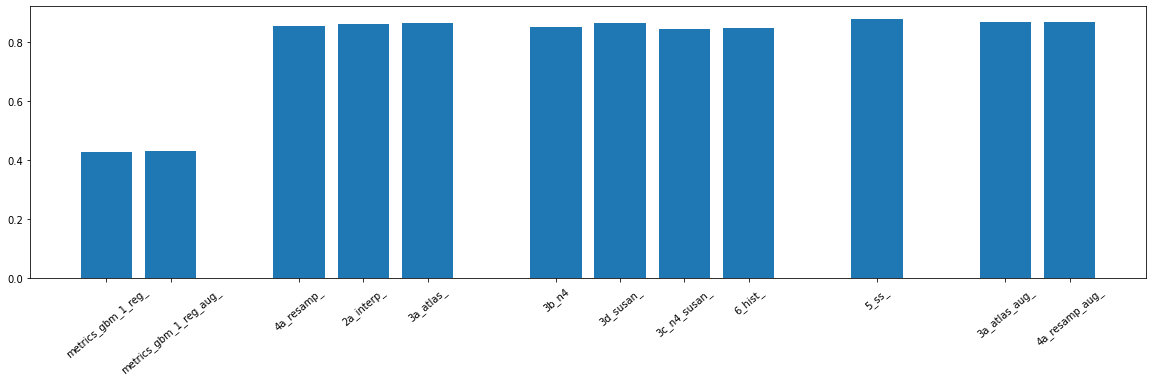

In [53]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt

# Make a random dataset:
height = [
0.429,
0.430,
0.853,
0.859,
0.864,
0.849,
0.865,
0.843,
0.848,
0.876,
0.868,
0.869]

bars = [
'metrics_gbm_1_reg_',
'metrics_gbm_1_reg_aug_',
'4a_resamp_',
'2a_interp_',
'3a_atlas_',
'3b_n4',
'3d_susan_',
'3c_n4_susan_',
'6_hist_',
'5_ss_',
'3a_atlas_aug_',
'4a_resamp_aug_']
# y_pos = np.arange(len(bars))

y_pos = [-2,-1,1,2,3,5,6,7,8, 10, 12,13]

plt.figure(figsize = [20,5])

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.xticks(rotation=40)

# Show graphic
plt.show();